In [1]:
#%run spectral_subtraction.ipynb
#%run /Volumes/Epilepsy_ECOG/CodeBase/Python/pypLine_methods.ipynb
#%run pypline_methods_FD_15Jul19.ipynb
#%run /Users/danielmaksumov/Documents/pypline/STRF_production/prepping_for_deployment_methods.ipynb
from ecogMethods import *
%matplotlib qt
%matplotlib inline
from sklearn.model_selection import train_test_split

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path as op
import sys
import h5py
import hdf5storage
import warnings
import scipy.stats as stats
from scipy.signal import resample_poly, convolve
import time
plt.ion()
plt.style.use('seaborn-white')

import mne
from mne.decoding import ReceptiveField
from sklearn.linear_model import *

from sklearn.model_selection import cross_val_score
import hdf5storage as h5
options= h5.Options(store_python_metadata=True)

# home = r'C:\Users\jeschj01\Documents\pypLine'

SJ = 'NY749'
task = "VisRead"
prod_bool = 1

# home = "/Users/danielmaksumov/Documents/pypline/"
# subj_dir = op.join(home, "STRF_Production/STRF_Phase4", SJ)
home = "/Users/danielmaksumov/ECoG/"
subj_dir = op.join(home, "Data", SJ)

In [2]:
audio_sfreq = 44100 # sound freq of audio samples as imported
spec_bandwidth = 8000 # desired bandwith bsased on natural speech
spec_win_time = 0.01 # Length of spectrogram frame in seconds
nyq_rate = 2*spec_bandwidth #16000Hz
fps_constant = int(1/spec_win_time) # 100 fps

ecog_fps=512
audio_length = 1 #seconds

# Time delay interval in seconds
delay_min, delay_max = -0.10,0.51 # Time delay interval in seconds

# Time delay interval in frames 
## currently hardcoding 100 for number of window frames
fmin, fmax = int(fps_constant * delay_min), int(fps_constant * delay_max)
window_length = fmax - fmin
print("delay window length is " + str(window_length))

delays = np.arange(np.round(fmin),
                   np.round(fmax).astype(int))
times = delays / float(fps_constant)

# plot dimensions
plot_dim_STRF = Plot_dim('', '', '','', '', '')

print("nyq rate is " + str(nyq_rate) + " Hz")
print("fps is " + str(fps_constant))

pth = op.join(home, "Subjs", SJ)
g = get_subj_globals(SJ, task, root_path=pth, NY=True, create_dir=False, from_mat=True, matDir=pth)
es = g.elecs
events = get_events(SJ, task, g.ANdir, from_mat=True, matDir=pth)
labels = h5.loadmat(op.join(g.DTdir, "Labels.mat"))

if SJ == "NY688" or SJ == "NY749":
    labels = [i[0][0] for i in labels["Labels"][0]]
else:
    labels = [i[0] for i in labels["Labels"][0]]
print("Some labels: " + str(labels[0:5]))

params = Params('','','','','','','','','')
params.st = -100
params.en = 1100 #audio_length*1000
params.scale = 0.8
params.baseline = False

if prod_bool == 0:
    params.response_lock = False
    print("no response lock")
else:
    params.response_lock = True
    print("yes response lock")


delay window length is 61
nyq rate is 16000 Hz
fps is 100
Some labels: ['G1', 'G2', 'G3', 'G4', 'G5']
yes response lock


In [3]:
## Load gdat and zoom data
load_gdat = h5.loadmat(op.join(g.DTdir, "gdat_CAR.mat"))
the_gdat = load_gdat['gdat']
shape_gdat = np.shape(the_gdat)
length_gdat = shape_gdat[1]

load_zoom = h5.loadmat(op.join(g.DTdir, "zoom.mat"))
the_zoom = load_zoom['zoom']
shape_zoom = np.shape(the_zoom)
length_zoom = shape_zoom[0]

# Verify theyre approx same length
print("gdat length is " + str(length_gdat) + " frames")
print("zoom length is " + str(length_zoom/audio_sfreq*ecog_fps) + " frames")

the_gdat = the_gdat[:, :-1] ## remove last frame, make lengths equal
print("adjusted gdat length is " + str(np.shape(the_gdat)[1]) + " frames")

gdat length is 136457 frames
zoom length is 136456.01088435375 frames
adjusted gdat length is 136456 frames


In [4]:
lat_fr = audio_length + abs(delay_min)
latency_frames_audio = lat_fr*audio_sfreq
print("used to index audio data,", str(latency_frames_audio))

if prod_bool == 0:
    onset = events.onset[3:]
    print("onset perc")
else:
    onset = events.onset_r[3:]
    print("onset prod")

onset_r_audio = [int(audio_sfreq/ecog_fps * onset) for onset in onset]
onset_r_audio_new = [int(onset - audio_sfreq*delay_max) for onset in onset_r_audio]
offset_r_audio = [onset+int(latency_frames_audio) for onset in onset_r_audio]
print(str((offset_r_audio[0] - onset_r_audio[0])/(lat_fr*audio_sfreq)) + " should be 1")

print("shape of zoom is " + str(np.shape(the_zoom[int(onset_r_audio[0]):int(offset_r_audio[0])].T)))
print("amount of zoom data we're getting is " + str(np.shape(the_zoom[int(onset_r_audio_new[0]):int(offset_r_audio[0])].T)))


used to index audio data, 48510.00000000001
onset prod
0.9999999999999999 should be 1
shape of zoom is (1, 48510)
amount of zoom data we're getting is (1, 71001)


In [5]:
# get trials from zoom
X_zoom = []
for i in range(len(onset_r_audio)):
    X_zoom.append(the_zoom[int(onset_r_audio_new[i]):int(offset_r_audio[i])].T[0])
    
print(str(np.shape(X_zoom)[0]) + " trials, " + str(np.shape(X_zoom)[1]) + " time points.")

num_trials = np.shape(X_zoom)[0]
print("There are " + str(num_trials) + " trials.")

100 trials, 71001 time points.
There are 100 trials.


/Users/danielmaksumov/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


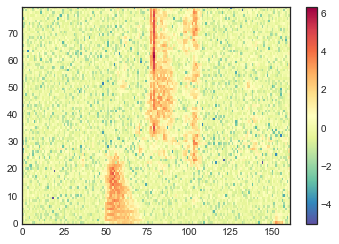

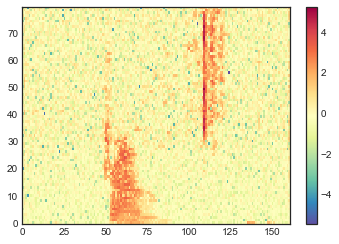

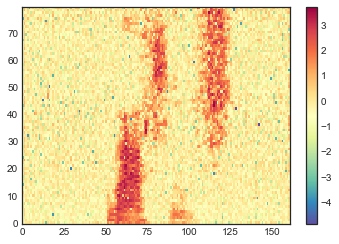

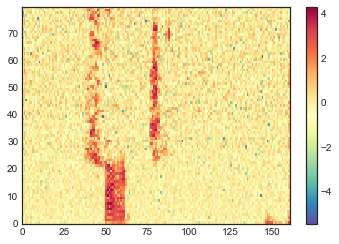

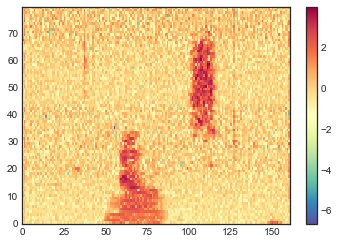

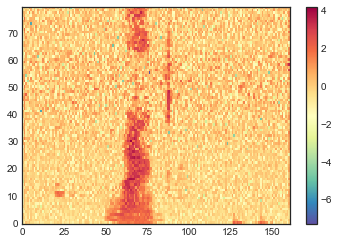

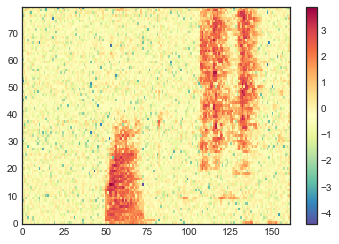

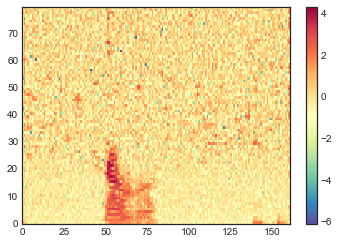

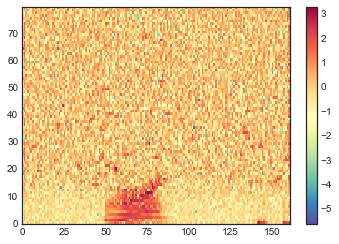

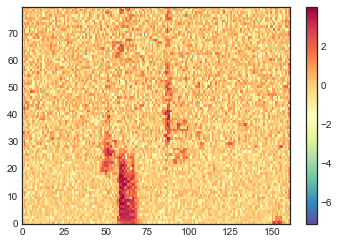

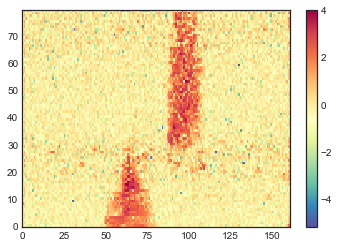

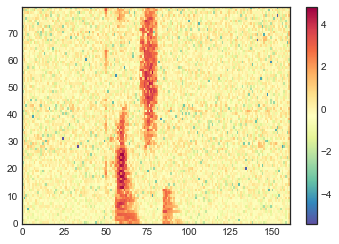

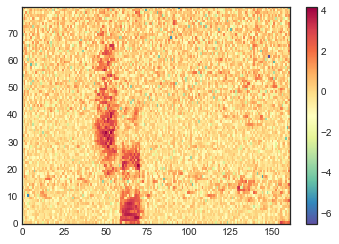

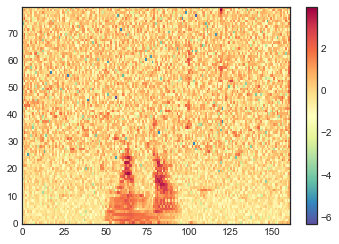

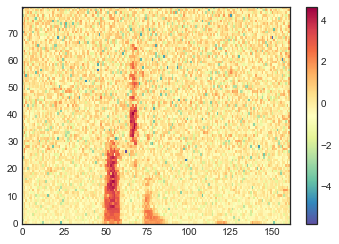

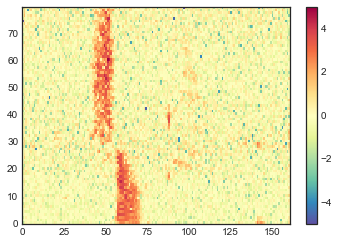

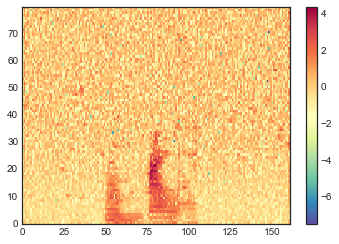

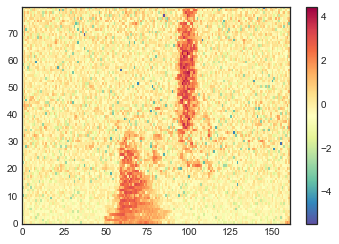

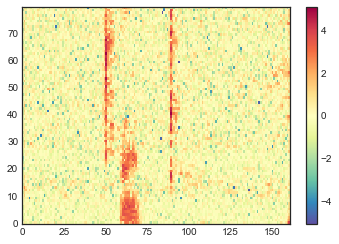

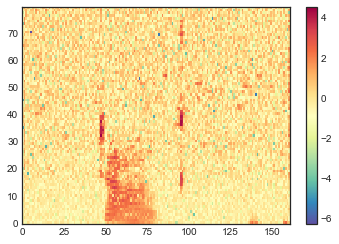

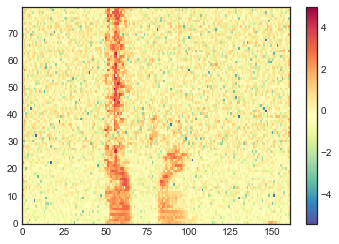

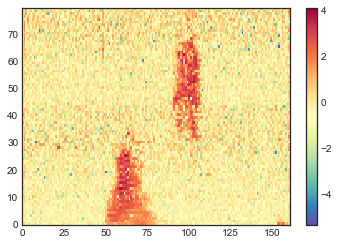

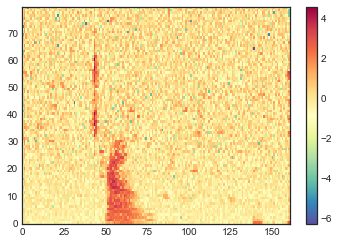

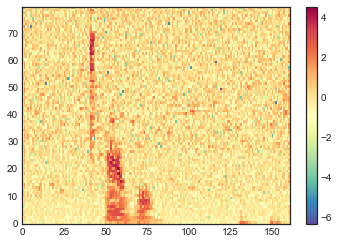

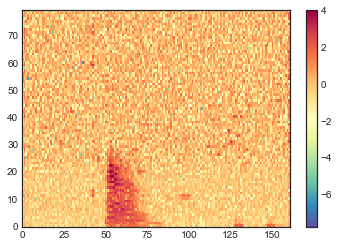

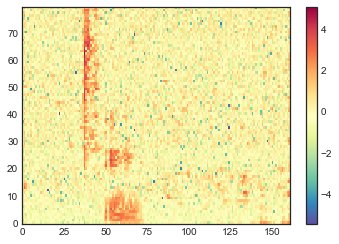

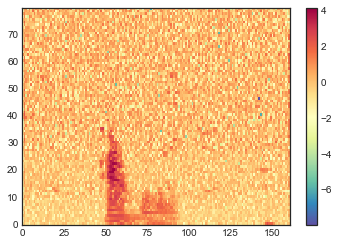

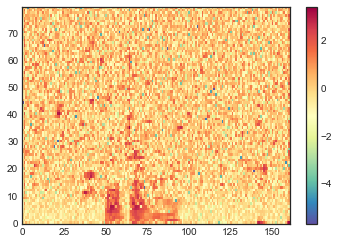

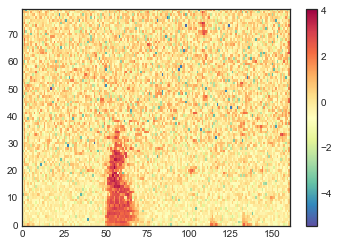

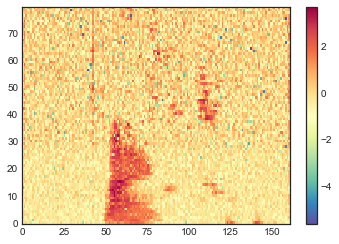

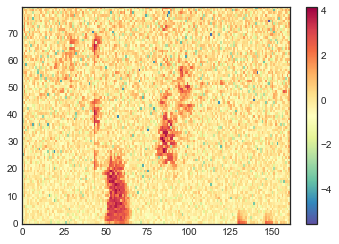

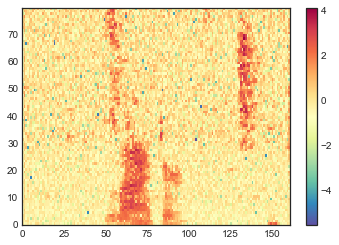

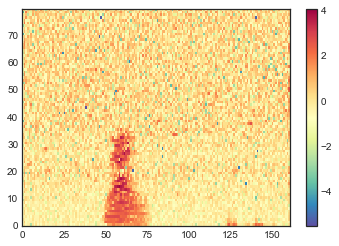

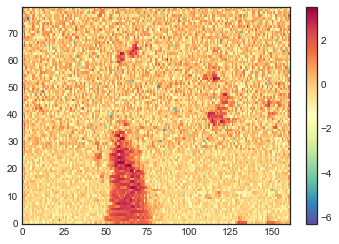

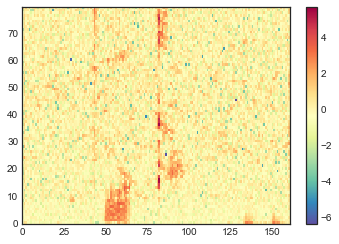

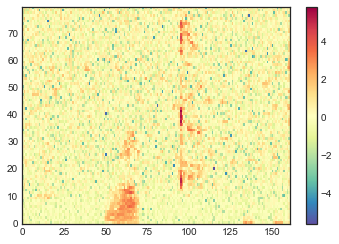

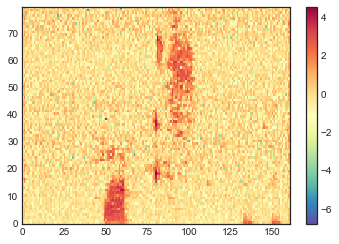

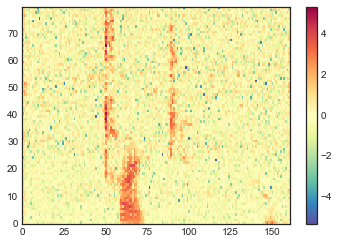

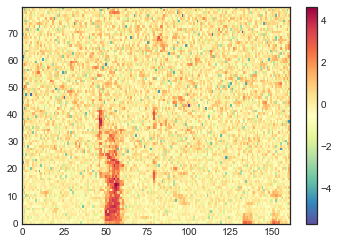

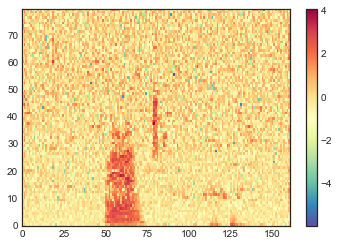

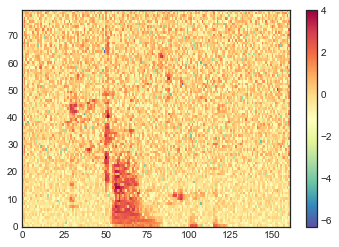

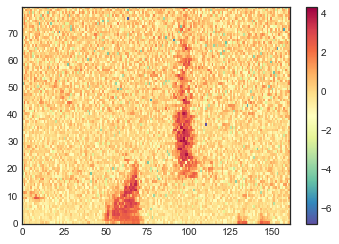

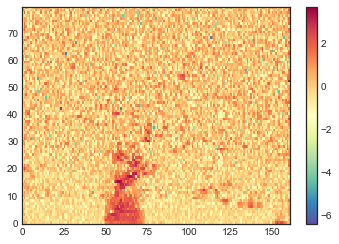

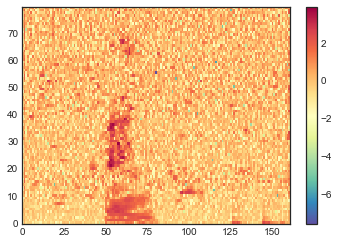

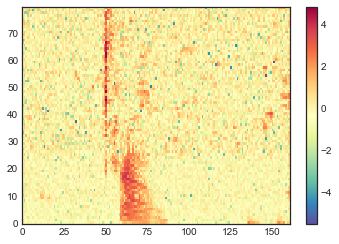

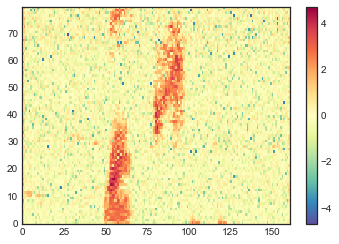

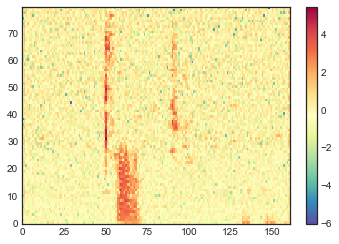

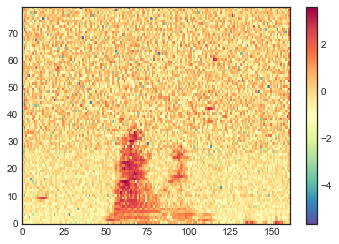

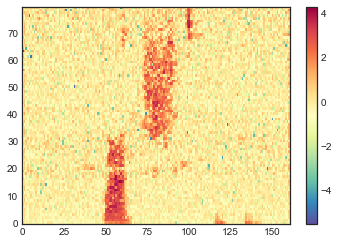

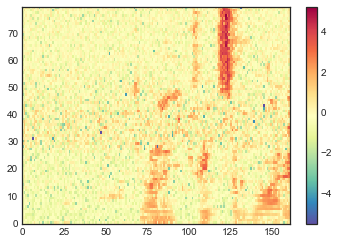

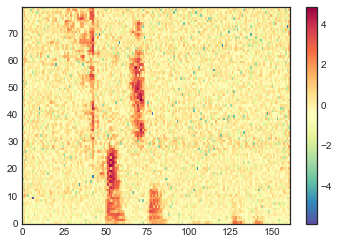

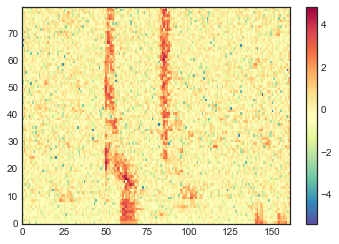

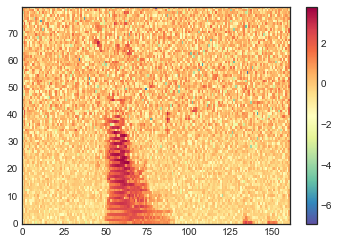

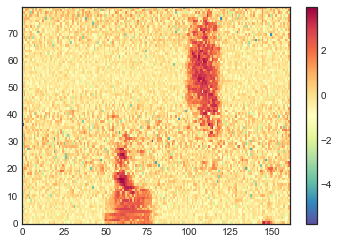

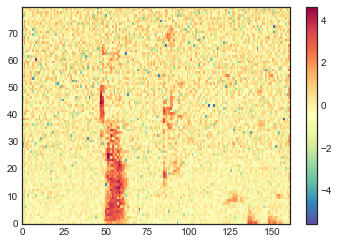

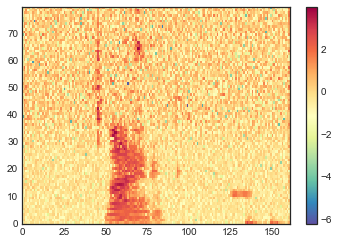

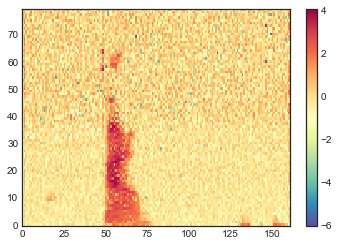

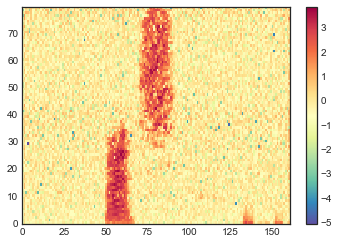

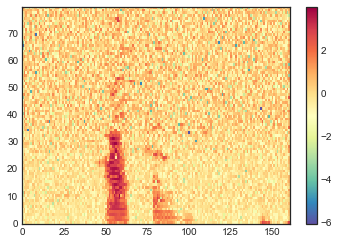

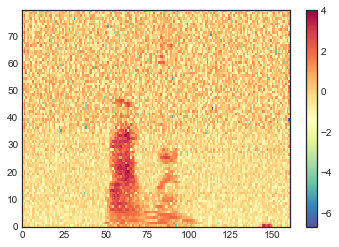

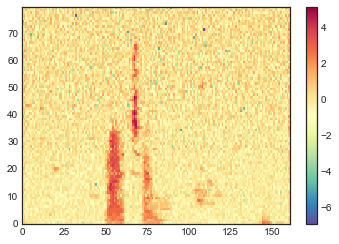

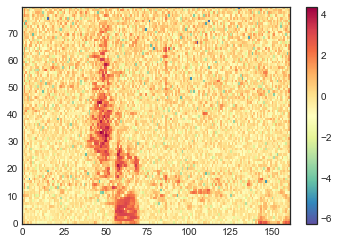

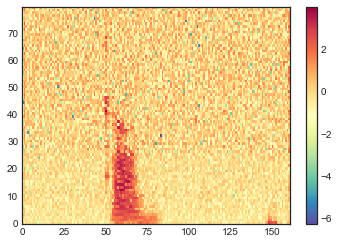

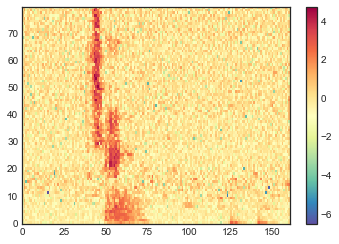

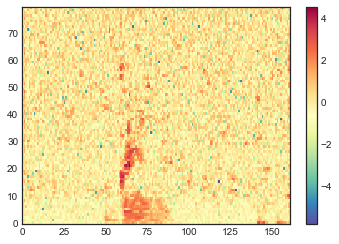

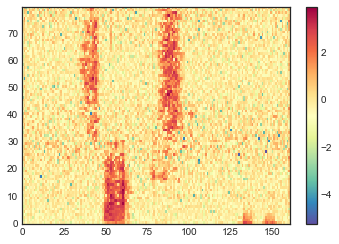

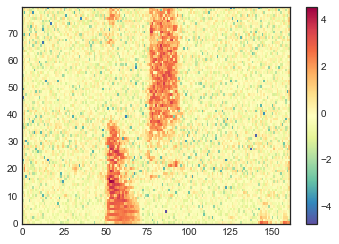

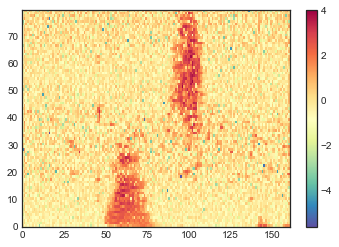

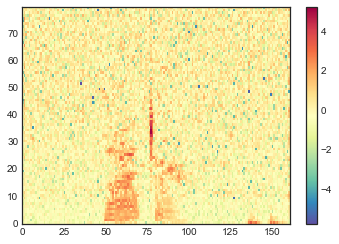

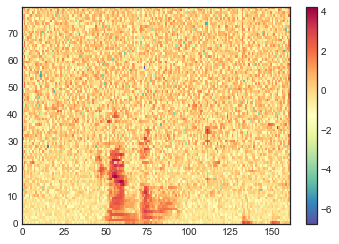

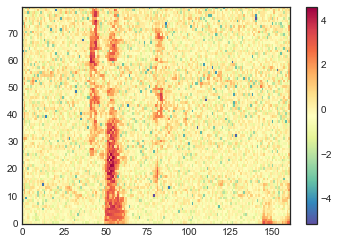

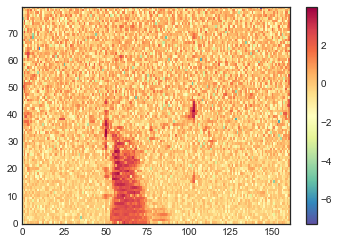

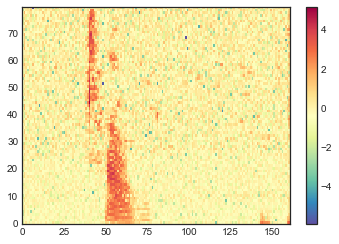

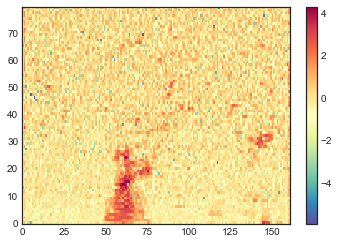

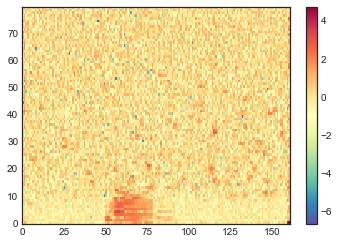

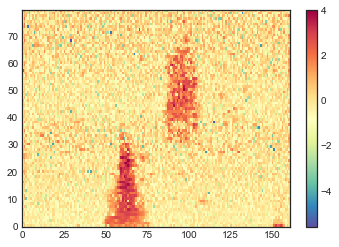

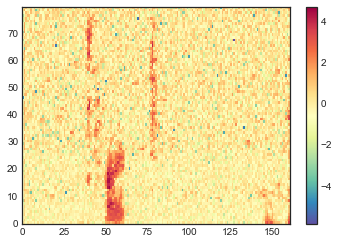

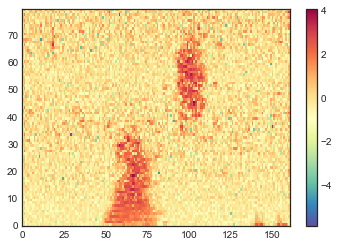

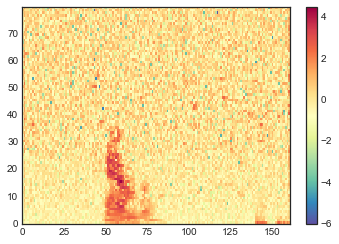

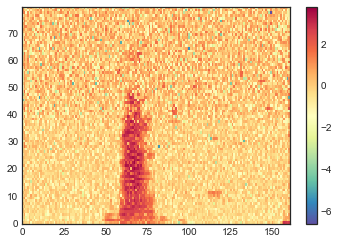

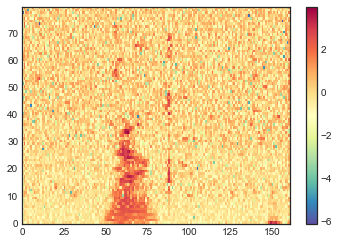

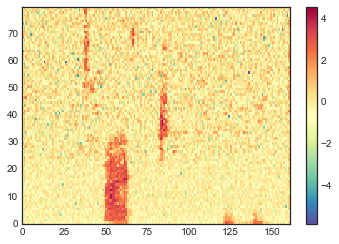

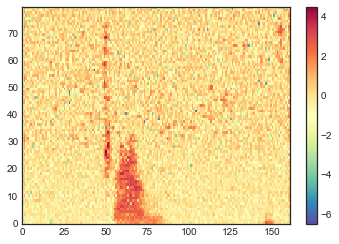

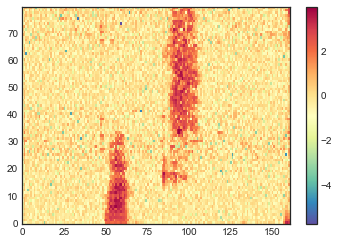

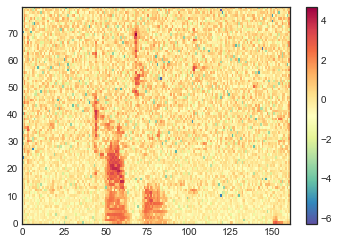

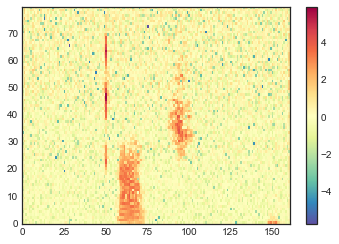

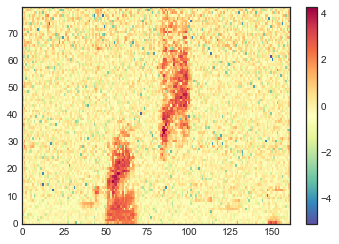

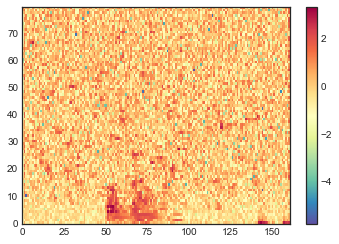

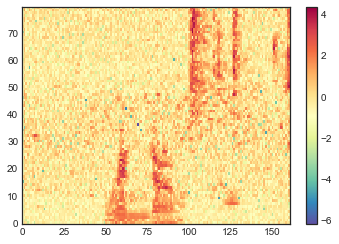

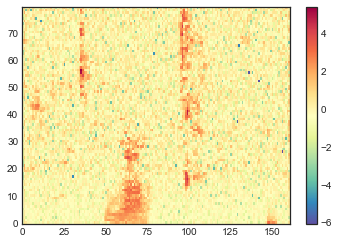

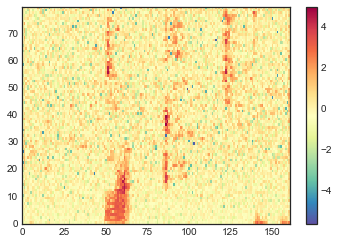

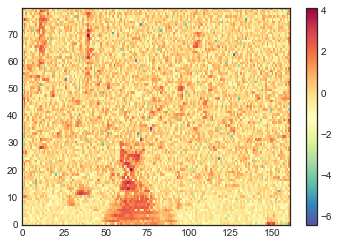

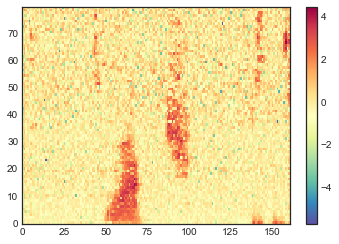

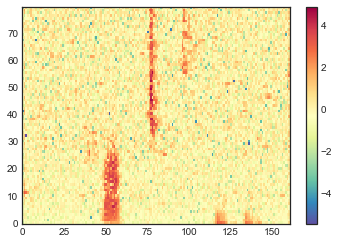

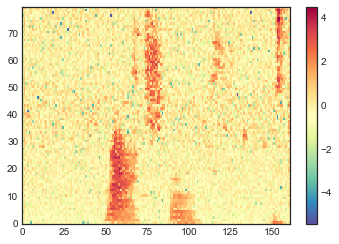

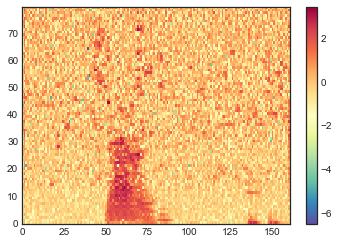

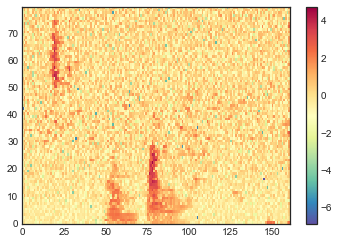

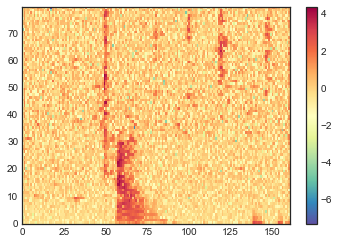

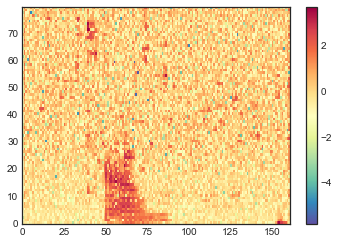

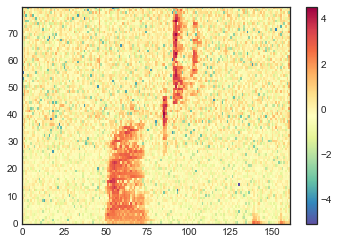

(100, 80, 161)
100 trials, 80 freqs, 161 time points


In [6]:
X_spec = []
#pds = []
for trial in X_zoom:  
    # Downsample the audio (usually from 96000Hz to 16000Hz)
    the_sig = resample_poly(trial, nyq_rate, audio_sfreq, axis=0)
    
    # Denoise and get clean spectrogram
    clean_spec = spectral_sub(plot_dim_STRF, signal = the_sig, fs = nyq_rate, spec_window_time=spec_win_time, spec_overlap_time=0, beta = 0.1, return_spec=True, zero_out = (1,0), compare_specs= False)

    norm_spec = stats.zscore(clean_spec, axis = 1)
    # avrg pad
    st_pad_post_stim = 70
    pad_until = (fmax - 1) + st_pad_post_stim # 51 - 1 + 70 = 120
    
    if task == "AudRep":
        if prod_bool == 0: #41
            time_to_pad = audio_length*fps_constant - (fmin - 1) - st_pad_post_stim #(audio_length*fps_constant + window_length)-pad_until
            pad_with = np.mean(norm_spec[:, :pad_until], axis = 1) 
            pad = np.full((time_to_pad, np.shape(norm_spec)[0]), pad_with).T
            norm_spec = np.concatenate((norm_spec[:, :pad_until], pad), axis = 1)

        else:
            time_to_pad = fmax - 1 # 50
            pad_with = np.mean(norm_spec[:, time_to_pad:], axis = 1) 
            pad = np.full((time_to_pad, np.shape(norm_spec)[0]), pad_with).T
            norm_spec = np.concatenate((pad, norm_spec[:, time_to_pad:]), axis = 1)

    plt.imshow(norm_spec, origin='lower', aspect='auto', cmap='Spectral_r')
    plt.colorbar()
    plt.show()
    X_spec.append(norm_spec) 
    
X_spec_dim = np.shape(X_spec)
print(X_spec_dim)
print(str(X_spec_dim[0]) + " trials, " + str(X_spec_dim[1]) + " freqs, " + str(X_spec_dim[2]) + " time points")


In [7]:
# Time delay
# Pad left, data right
n_freq = X_spec_dim[1]
X_spec = np.asarray(X_spec)

X = []

for i in range(fmin, fmax):
    if i == fmin:
        the_data = X_spec[:, :, fmax-i-1:]
    else:
        the_data = X_spec[:, :, fmax-i-1: fmin-i]

    the_data = np.concatenate(the_data, axis = 1)
    X.append(the_data)

X = np.concatenate(X, axis = 0)
print(np.shape(X))
## save X

if task == 'AudRep':
    if prod_bool == 0:
        if not op.isdir(op.join(subj_dir, "Perception")):
            os.mkdir(op.join(subj_dir, "Perception"))
        save_h5(op.join(subj_dir, "Perception", "X_perception.h5"), "X", X)
    else:
        if not op.isdir(op.join(subj_dir, "Production")):
            os.mkdir(op.join(subj_dir, "Production"))
        save_h5(op.join(subj_dir, "Production", "X_production.h5"), "X", X)
elif task == 'VisRead':
    if not op.isdir(op.join(subj_dir, "Visread")):
        os.mkdir(op.join(subj_dir, "Visread"))
    save_h5(op.join(subj_dir, "Visread", "X_visread.h5"), "X", X)
else:
    warnings.warn("Wrong task to save data from.")

(4880, 10100)


/Users/danielmaksumov/ECoG/ECoGpypeline/ecogMethods/__init__.py:620: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if gdat == '':


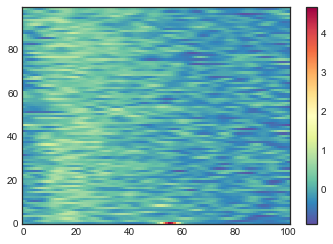

In [8]:
elecs_path = op.join(subj_dir, str(SJ) + "_elecs.h5")
elecs_list = [] 

if not op.exists(elecs_path):
    if not elecs_list:
        warnings.warn("Which electrodes do we want? Please provide a list or path.")
else:
    elecs_list = load_h5(elecs_path, 'elecs')

## if elecs_list empty, find from directory
## else, use list given
elecs_ind = [e-1 for e in elecs_list]

elecs = iter(elecs_ind)
the_ys = []

for i,j in enumerate(elecs):
    the_y = plot_single(SJ, task, j, params, root_path=pth, f1=70, gdat = the_gdat, from_mat=True, matDir=pth)
    
    the_y_ds = resample_poly(the_y, 120, 1200, axis = 1)

    wind = np.hanning(10)
    trials = []
    for trial in the_y_ds:
        new_trial = convolve(trial , wind,'same')/sum(wind)
        new_trial = stats.zscore(new_trial)
        trials.append(new_trial)
    trials = np.asarray(trials)
    
    the_ys.append(trials[:, 10:-9])
    
the_ys = np.asarray(the_ys)

plt.imshow(np.mean(the_ys, axis = 0), origin='lower', aspect='auto', cmap='Spectral_r')
plt.colorbar()
y_str = "y_TrialsxTime"

if task == 'AudRep':
    if prod_bool == 0:
        save_h5(op.join(subj_dir, "Perception" ,"y_perception.h5"), "y", the_ys)
        plt.savefig(op.join(subj_dir, "Perception", y_str))
    else:
        save_h5(op.join(subj_dir, "Production", "y_production.h5"), "y", the_ys)
        plt.savefig(op.join(subj_dir, "Production", y_str))
elif task == 'VisRead':
    save_h5(op.join(subj_dir, "Visread", "y_visread.h5"), "y", the_ys)
    plt.savefig(op.join(subj_dir, "Visread", y_str))
else:
    warnings.warn("Wrong task to save data from.")

plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

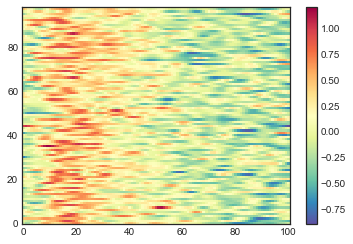

In [14]:
plt.imshow(np.mean(the_ys[:, 1:], axis = 0), origin='lower', aspect='auto', cmap='Spectral_r')
plt.colorbar()
plt.show

np.shape(the_ys)
for i in the_ys:
    plt.imshow(i, origin='lower', aspect='auto', cmap='Spectral_r')
    plt.colorbar()
    plt.show()
    

In [15]:
# Where we will store the scores for each ridge
my_scores, my_weights = [], []

elecs = iter(elecs_ind)
#task_dir = '/Users/danielmaksumov/Documents/pypline/STRF_production/STRFs_Apr2020/VisRead/New_NN1M/'

if task == 'AudRep':
    if prod_bool == 0:
        data_path = op.join(subj_dir, "Perception")
        file = open(op.join(data_path,'perc_results.txt'),"w")
    else:
        data_path = op.join(subj_dir, "Production")
        file = open(op.join(data_path,'prod_results.txt'),"w")
elif task == "VisRead":
    data_path = op.join(subj_dir, "Visread")
    file = open(op.join(data_path,'visread_results.txt'),"w")
else:
    warnings.warn("Wrong task to save data from.")
    
for i,j in enumerate(elecs):

    y = np.concatenate(the_ys[i], axis = 0)

    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size = 0.2)
    # Run ridge through a series of alphas
    alpha_scores = []
    alpha_weights = []

    # Run a ridge regression using stochastic gradient descent w early stopping
    clf = RidgeCV(alphas = [1e6], scoring = 'r2', cv=5)
    clf.fit(X_train, y_train)
    the_score = clf.score(X_test, y_test)
    alpha_scores.append(the_score)
    alpha_weights.append(clf.coef_)

    results = str(labels[j]) + " is " + str(round(the_score, 4))        
    print(results)
    file.write(results + str("\n"))

    # Store the scores into a list and print the score for each electrode
    my_scores.append(alpha_scores)
    my_weights.append(alpha_weights)
    
file.close()

G7 is 0.0048
G15 is 0.1068
G29 is 0.2534
G34 is 0.0111
G35 is 0.0147
G36 is 0.0137
G45 is 0.0512
G46 is 0.2358
G47 is 0.1251
G48 is 0.0617
G54 is 0.0436
G55 is 0.0115
G56 is 0.0288
G89 is 0.0561
G111 is 0.0164
G113 is 0.0024
G117 is 0.0387
G118 is 0.039
G119 is 0.0613
G120 is 0.2362
G121 is 0.0875
G122 is 0.064
G125 is 0.0555
G126 is 0.134
G127 is 0.1438
IT4 is 0.0149
PT3 is 0.0001
DPI4 is 0.026


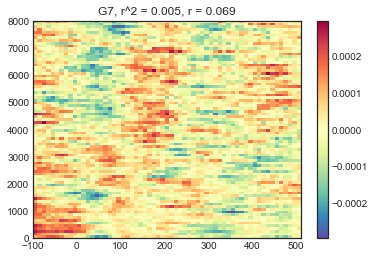

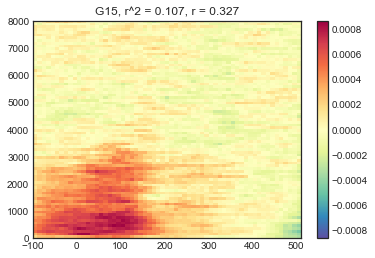

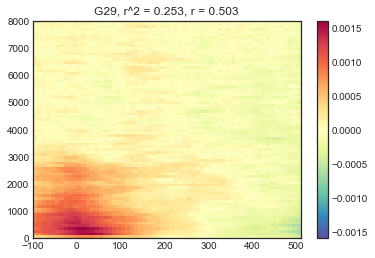

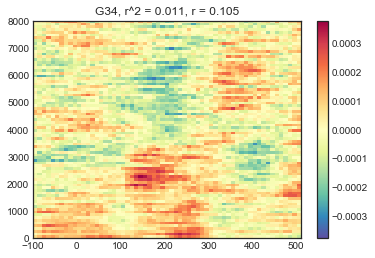

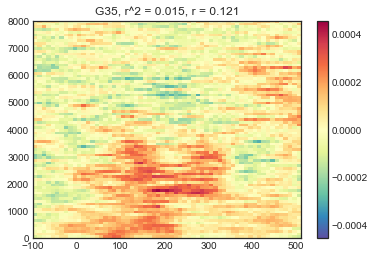

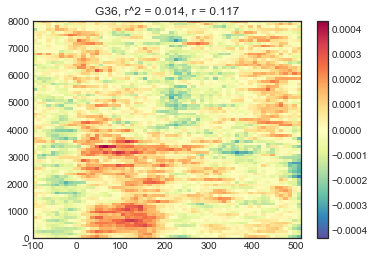

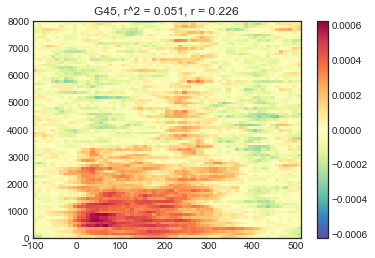

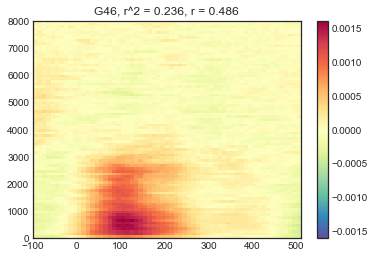

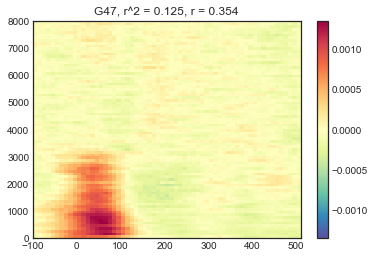

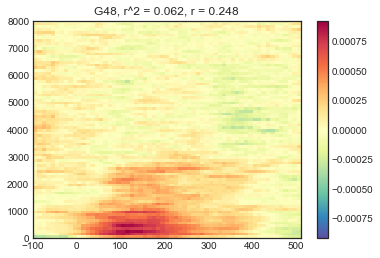

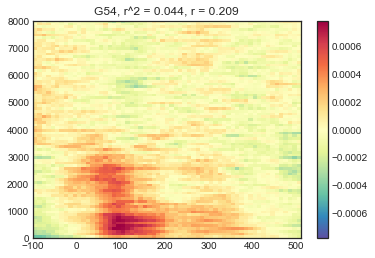

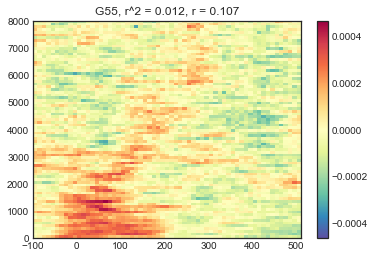

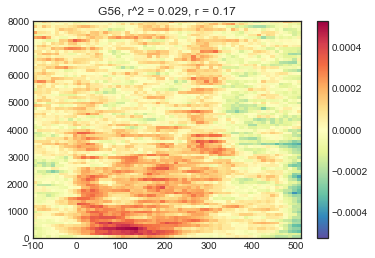

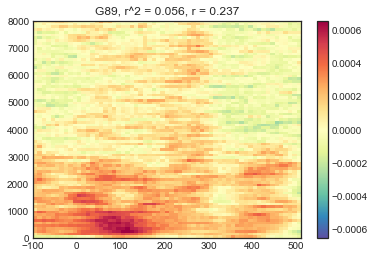

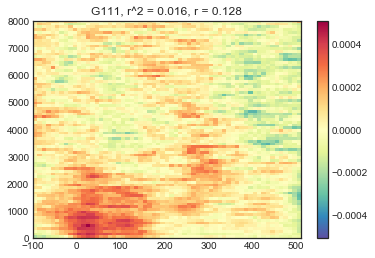

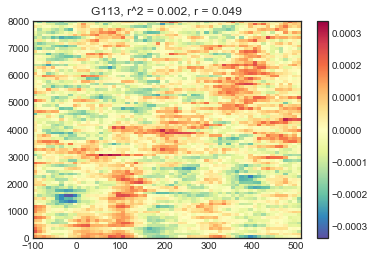

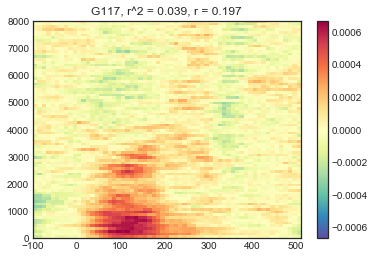

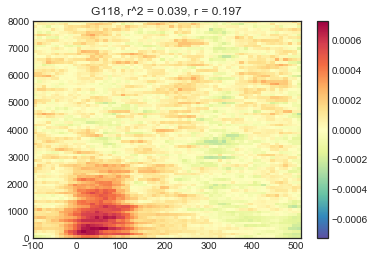

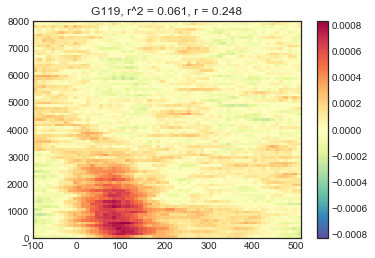

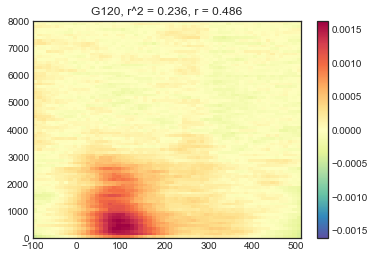

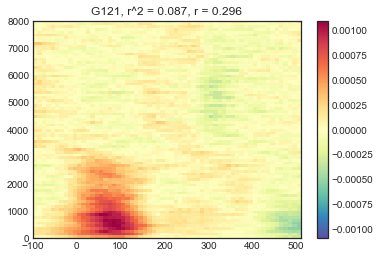

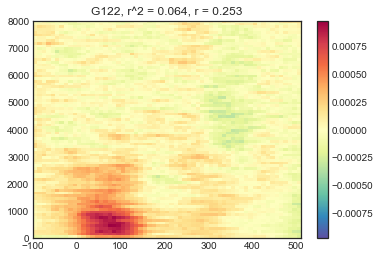

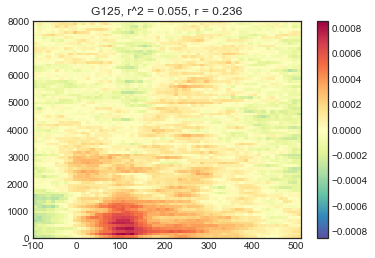

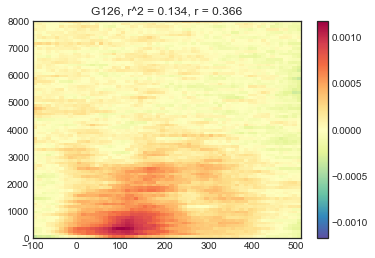

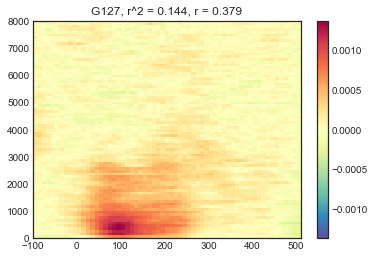

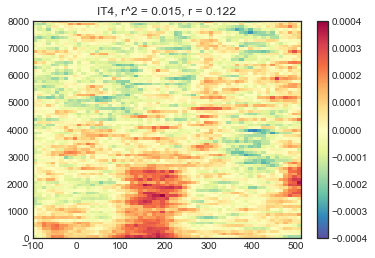

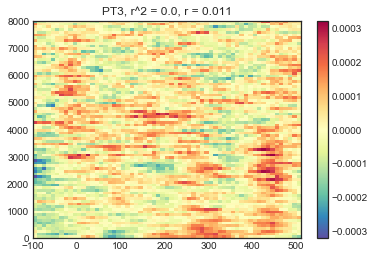

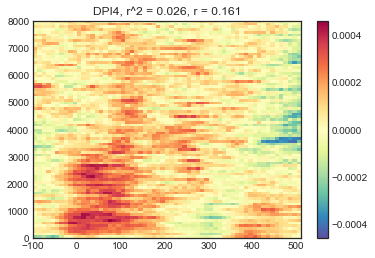

/Users/danielmaksumov/anaconda3/envs/mne/lib/python3.6/site-packages/hdf5storage/__init__.py:1306: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filename)


In [16]:
kernels = []
good_labels = np.asarray(labels)[elecs_ind]

for ind, el in enumerate(my_weights):
    weights = el[0]
    kernel = weights.reshape(window_length, n_freq).T
    kernels.append(kernel)
    extent = [int(delay_min*1000), int(delay_max*1000), 0, 8000]
    ker_max = np.amax(abs(kernel))
    if my_scores[ind][0] <= 0:
        my_scores[ind][0] = 0
    plt.imshow(kernel, origin='lower', cmap = 'Spectral_r', vmax = ker_max, vmin = -ker_max, extent = extent, aspect = 'auto')
    plt.title(str(good_labels[ind]) + ", r^2 = " + str(round(my_scores[ind][0], 3)) + ", r = " + str(round(math.sqrt(my_scores[ind][0]), 3)))
    plt.colorbar()
    el_str = str(good_labels[ind]) + '.png'
    plt.savefig(op.join(data_path, el_str ))
    plt.show()
    
if task == 'AudRep':
    if prod_bool == 0:
        data_dict = {str(good_labels[i] + "_" + SJ + "_" + "perc") : (round(my_scores[i][0],3),kernels[i]) for i in range(len(good_labels))}
    else:
        data_dict = {str(good_labels[i] + "_" + SJ + "_" + "prod") : (round(my_scores[i][0],3),kernels[i]) for i in range(len(good_labels))}
elif task == 'VisRead':
    data_dict = {str(good_labels[i] + "_" + SJ + "_" + "visread") : (round(my_scores[i][0],3),kernels[i]) for i in range(len(good_labels))}

h5_dir = op.join(data_path, str(SJ) + '_data')
h5.savemat(mdict = data_dict, file_name = h5_dir, options = options)

In [ ]:
h5.loadmat(h5_dir)

data_dict.keys()
data_dict['LGA10_NY717'] = data_dict.pop('LGA10') 
for label in good_labels[3:]:
    exec("data_dict['" + label + "_" + SJ + "'] = data_dict.pop('" + label + "')")
    
h5_dir = op.join(data_path, 'data')
h5.savemat(mdict = data_dict, file_name = h5_dir, options = options)
h5.loadmat('/Users/danielmaksumov/STRF_Phase5/NY717/Production/data.mat')

SJs = ["NY688", "NY742", "NY749"]
tasks = ["Perception", "Production", "Visread"]
home = "/Users/danielmaksumov/STRF_Phase5"

for SJ in SJs:
    subj_dir = op.join(home, SJ)
    pth = op.join(home, "Subjs", SJ)
    
    for task in tasks:
        if task == "Visread":
            g = get_subj_globals(SJ, "VisRead", root_path=pth, NY=True, create_dir=False, from_mat=True, matDir=pth)
        else:
            g = get_subj_globals(SJ, "AudRep", root_path=pth, NY=True, create_dir=False, from_mat=True, matDir=pth)
            
        labels = h5.loadmat(op.join(g.DTdir, "Labels.mat"))
        if SJ == "NY688" or SJ == "NY749":
            labels = [i[0][0] for i in labels["Labels"][0]]
        else:
            labels = [i[0] for i in labels["Labels"][0]]
    
        elecs_path = op.join(subj_dir, str(SJ) + "_elecs.h5")

        elecs_list = load_h5(elecs_path, 'elecs')

        elecs_ind = [e-1 for e in elecs_list]

        good_labels = np.asarray(labels)[elecs_ind]
    
        data_path = op.join(subj_dir, task)
        the_data = h5.loadmat(op.join(data_path, "data.mat"))
        
        for label in good_labels:
            exec("the_data['" + label + "_" + SJ + "'] = the_data.pop('" + label + "')")
        h5_dir = op.join(data_path, 'data')
        h5.savemat(mdict = the_data, file_name = h5_dir, options = options)

the_data = h5.loadmat(op.join('/Users/danielmaksumov/STRF_Phase5/NY742/Visread', "data.mat"))
the_data

elecs_path = op.join(subj_dir, str(SJ) + "_elecs.h5")

elecs_list = load_h5(elecs_path, 'elecs')

elecs_ind = [e-1 for e in elecs_list]

good_labels = np.asarray(labels)[elecs_ind]

data_path